In [11]:
# 판다스와 넘파이
import pandas as pd
import numpy as np

# 이미지
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#머신러닝
import lightgbm as lgb
from lightgbm import LGBMRegressor

# 검증 평가
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 기타
from tqdm import tqdm
import warnings ; warnings.filterwarnings('ignore')

In [3]:
# 나눔 폰트 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

'sudo'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'sudo'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [4]:
from google.colab import drive
drive.mount('./content')

ModuleNotFoundError: No module named 'google'

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['font.family'] = 'NanumBarunGothic'
%config inlinebackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 100 

## 1. 데이터 전처리

In [19]:
# path = '/content/content/MyDrive/[ML DL] data/[Dacon]전력사용량 예측 AI 경진대회/'

train = pd.read_csv('train.csv', encoding='cp949')
train['date_time'] = pd.to_datetime(train['date_time'])
test = pd.read_csv('test.csv', encoding='cp949')
test['date_time'] = pd.to_datetime(test['date_time'])

sample_submission = pd.read_csv('sample_submission.csv', encoding='cp949')

In [20]:
train.info()
print('=' * 50)
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   num         122400 non-null  int64         
 1   date_time   122400 non-null  datetime64[ns]
 2   전력사용량(kWh)  122400 non-null  float64       
 3   기온(°C)      122400 non-null  float64       
 4   풍속(m/s)     122400 non-null  float64       
 5   습도(%)       122400 non-null  float64       
 6   강수량(mm)     122400 non-null  float64       
 7   일조(hr)      122400 non-null  float64       
 8   비전기냉방설비운영   122400 non-null  float64       
 9   태양광보유       122400 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 9.3 MB


num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64

In [21]:
test.info()
print('=' * 50)
test.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   num           10080 non-null  int64         
 1   date_time     10080 non-null  datetime64[ns]
 2   기온(°C)        3360 non-null   float64       
 3   풍속(m/s)       3360 non-null   float64       
 4   습도(%)         3360 non-null   float64       
 5   강수량(mm, 6시간)  1680 non-null   float64       
 6   일조(hr, 3시간)   3360 non-null   float64       
 7   비전기냉방설비운영     2296 non-null   float64       
 8   태양광보유         1624 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 708.9 KB


num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64

### 1-1. 결측치 처리

- train 데이터의 기간동안 비전기냉방설운영 형태나 태양광보유 상황이 달라지지 않은 것으로 보여, 현재의 값들로 test 데이터의 Null값을 채웁니다.
- 기온/풍속/습도/강수령/일조데이터는 선형보간으로 값을 채웁니다.

In [23]:
# 같은 이름에 대해서는 출력하지 않는다.

train.drop_duplicates(subset = ['num', '비전기냉방설비운영', '태양광보유']).dropna()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
2040,2,2020-06-01,977.184,18.3,2.5,94.0,0.0,0.0,1.0,0.0
4080,3,2020-06-01,3183.624,17.0,2.0,100.0,1.1,0.0,1.0,1.0
6120,4,2020-06-01,339.552,22.6,0.7,62.0,0.0,0.0,1.0,1.0
8160,5,2020-06-01,3063.744,18.3,2.5,94.0,0.0,0.0,1.0,0.0
10200,6,2020-06-01,527.580,17.0,2.0,100.0,1.1,0.0,0.0,0.0
12240,7,2020-06-01,1313.658,17.6,2.5,92.0,0.8,0.0,1.0,0.0
14280,8,2020-06-01,4801.977,19.1,1.1,73.0,0.0,0.0,1.0,1.0
16320,9,2020-06-01,1255.932,20.3,1.1,74.0,0.0,0.0,0.0,1.0
18360,10,2020-06-01,417.960,18.3,2.5,94.0,0.0,0.0,1.0,0.0


In [27]:
sun = train.groupby('num')['태양광보유'].unique()
non_ele = train.groupby('num')['비전기냉방설비운영'].unique()

In [28]:
i = 0
train.loc[train['num']==(i+1), '태양광보유' ]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2035    0.0
2036    0.0
2037    0.0
2038    0.0
2039    0.0
Name: 태양광보유, Length: 2040, dtype: float64

In [32]:
#for i in range(60):
#    test.loc[test['num']==(i+1), '태양광보유'] = train.loc[train['num']==(i+1), '태양광보유'].unique()

In [30]:
test['태양광보유'] = test['num'].map(sun).astype(int)
test['비전기냉방설비운영'] = test['num'].map(non_ele).astype(int)

In [33]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.000000,0,0
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.000000,0,0
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.000000,0,0
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.000000,0,0
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.000000,0,0
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,28.633333,3.566667,66.000000,0.0,0.533333,1,1
10076,60,2020-08-31 20:00:00,28.266667,3.833333,67.000000,0.0,0.266667,1,1
10077,60,2020-08-31 21:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1,1
10078,60,2020-08-31 22:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1,1


In [35]:
test = test.interpolate()
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.0,0,0
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.0,0,0
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.0,0,0
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.0,0,0
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.0,0,0


### 1-2. feature engineering

In [37]:
# date_time에서 요일과 시간 추출
train['weekday'] = train['date_time'].dt.weekday + 1
train['hour'] = train['date_time'].dt.hour

test['weekday'] = test['date_time'].dt.weekday + 1
test['hour'] = test['date_time'].dt.hour

In [39]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,weekday,hour
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,1,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,1
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,1,2
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,1,3
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,1,4


In [40]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,weekday,hour
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.0,0,0,2,0
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.0,0,0,2,1
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.0,0,0,2,2
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.0,0,0,2,3
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.0,0,0,2,4


- 전력사용 패턴에 따른 건물별 clustering의 아이디어는 
[세아아부지](https://dacon.io/competitions/official/235736/codeshare/2643?page=1&dtype=recent)님의 Analytics를 참고했습니다.

In [45]:
from sklearn.cluster import k_means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

d_list = []
for i in range(1, 61):
    d = train[train['num'] == i].copy()
    d['전력사용량(kWh)'] = scaler.fit_transform(d['전력사용량(kWh)'].values.reshape(-1,1))
    d_ = d.groupby(['weekday', 'hour'])['전력사용량(kWh)'].mean().unstack()
    d_list.append(d_.to_numpy())

# 정규화된 시간-요일별 전력사용량을 이미지처럼 저장
d_list = np.array(d_list)

In [49]:
i = 1
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,weekday,hour
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,1,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,1
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,1,2
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,1,3
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,1,19
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,1,20
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,1,21
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,1,22


In [50]:
d_list_ = d_list.reshape(60, -1)
model = KMeans(init="k-means++", n_clusters=4, random_state=0)
model.fit(d_list_)

KMeans(n_clusters=4, random_state=0)

In [51]:
cluster = model.labels_
pd.DataFrame(cluster).value_counts()

0    31
1    17
3     7
2     5
dtype: int64

In [70]:
pd.DataFrame(cluster)[0]

0     2
1     0
2     2
3     1
4     2
5     0
6     0
7     0
8     2
9     1
10    1
11    1
12    0
13    0
14    2
15    0
16    0
17    0
18    3
19    3
20    3
21    0
22    0
23    0
24    0
25    0
26    0
27    1
28    1
29    1
30    1
31    1
32    0
33    3
34    0
35    1
36    0
37    1
38    1
39    1
40    1
41    1
42    0
43    0
44    0
45    0
46    0
47    0
48    3
49    3
50    3
51    0
52    0
53    0
54    0
55    0
56    0
57    0
58    1
59    1
Name: 0, dtype: int32

- K-means 군집화로 60개 건물의 시간-요일별 전력사용량 이미지를 4개로 분류했습니다.

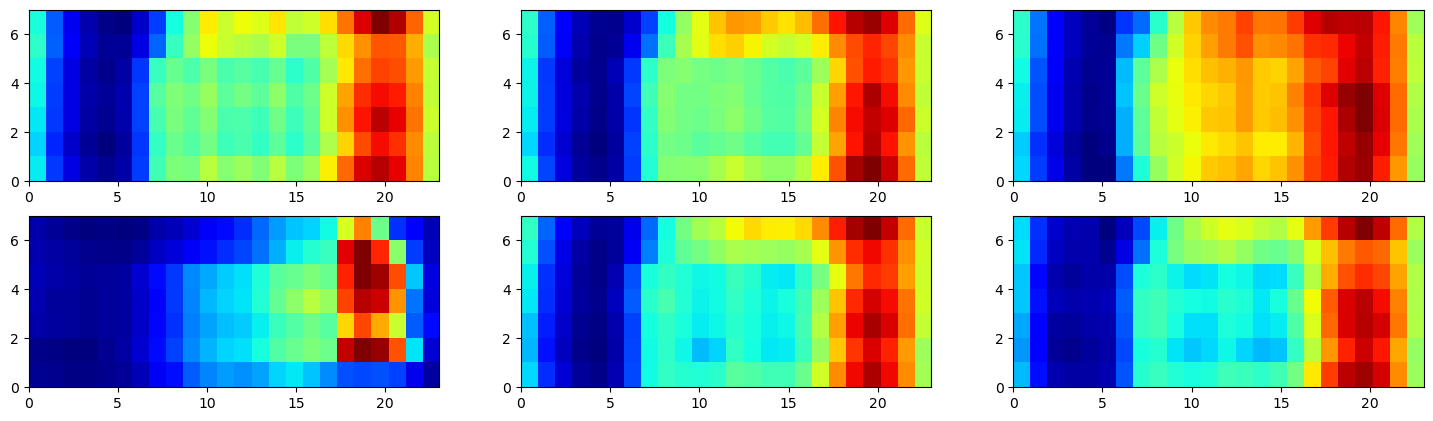

In [71]:
idx = cluster == 3
d_list = d_list.reshape(60, 7, 24)


fig, axes = plt.subplots(2, int(len(d_list[idx])/2), figsize = (18, 5))
axes = axes.flatten()

for d, ax in zip(d_list[idx], axes):
    d_ = scaler.inverse_transform(d)
    
    ax.imshow(d_, cmap = 'jet', aspect = 'auto', extent=[0, 23, 0, 7], origin = 'lower')

In [72]:
cluster_map = {i+1 : c for i, c in enumerate(cluster)}
train['cluster'] = train['num'].map(cluster_map)
test['cluster'] = test['num'].map(cluster_map)

In [73]:
cluster_map

{1: 2,
 2: 0,
 3: 2,
 4: 1,
 5: 2,
 6: 0,
 7: 0,
 8: 0,
 9: 2,
 10: 1,
 11: 1,
 12: 1,
 13: 0,
 14: 0,
 15: 2,
 16: 0,
 17: 0,
 18: 0,
 19: 3,
 20: 3,
 21: 3,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 0,
 34: 3,
 35: 0,
 36: 1,
 37: 0,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 3,
 50: 3,
 51: 3,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 1,
 60: 1}

In [74]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,weekday,hour,cluster
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,1,0,2
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,1,2
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,1,2,2
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,1,3,2
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,1,19,1
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,1,20,1
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,1,21,1
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,1,22,1


In [75]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,weekday,hour,cluster
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.000000,0,0,2,0,2
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.000000,0,0,2,1,2
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.000000,0,0,2,2,2
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.000000,0,0,2,3,2
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.000000,0,0,2,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,28.633333,3.566667,66.000000,0.0,0.533333,1,1,1,19,1
10076,60,2020-08-31 20:00:00,28.266667,3.833333,67.000000,0.0,0.266667,1,1,1,20,1
10077,60,2020-08-31 21:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1,1,1,21,1
10078,60,2020-08-31 22:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1,1,1,22,1


In [76]:
i = 40
train[train['num']==1][['cluster']]

,cluster
0,2
1,2
2,2
3,2
4,2
...,...
2035,2
2036,2
2037,2
2038,2


## 2. Modeling
- K-fold와 lgbm으로 모델을 구성합니다

In [80]:
# input, output  을 나눈다.

X = train.drop(['date_time', '전력사용량(kWh)'], axis = 1)
y = train['전력사용량(kWh)']
X_test = test.drop('date_time', axis = 1)

In [81]:
X.head()

,num,기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,weekday,hour,cluster
0,1,17.6,2.5,92.0,0.8,0.0,0.0,0.0,1,0,2
1,1,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,1,2
2,1,17.5,3.2,91.0,0.0,0.0,0.0,0.0,1,2,2
3,1,17.1,3.2,91.0,0.0,0.0,0.0,0.0,1,3,2
4,1,17.0,3.3,92.0,0.0,0.0,0.0,0.0,1,4,2


In [82]:
y

0         8179.056
1         8135.640
2         8107.128
3         8048.808
4         8043.624
            ...   
122395    4114.368
122396    3975.696
122397    3572.208
122398    3299.184
122399    3204.576
Name: 전력사용량(kWh), Length: 122400, dtype: float64

In [83]:
X_test

,num,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,weekday,hour,cluster
0,1,27.800000,1.500000,74.000000,0.0,0.000000,0,0,2,0,2
1,1,27.633333,1.366667,75.333333,0.0,0.000000,0,0,2,1,2
2,1,27.466667,1.233333,76.666667,0.0,0.000000,0,0,2,2,2
3,1,27.300000,1.100000,78.000000,0.0,0.000000,0,0,2,3,2
4,1,26.900000,1.166667,79.666667,0.0,0.000000,0,0,2,4,2
...,...,...,...,...,...,...,...,...,...,...,...
10075,60,28.633333,3.566667,66.000000,0.0,0.533333,1,1,1,19,1
10076,60,28.266667,3.833333,67.000000,0.0,0.266667,1,1,1,20,1
10077,60,27.900000,4.100000,68.000000,0.0,0.000000,1,1,1,21,1
10078,60,27.900000,4.100000,68.000000,0.0,0.000000,1,1,1,22,1


In [84]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold

# 검증용 20%, 학습용 80% 실행된다.
n_splits = 5
sfk = StratifiedKFold(n_splits = n_splits)

y_pred = np.zeros(len(X_test))

# train데이터셋에서 건물의 비율을 동일하게하기 위해 StratifiedKFold 사용
# num 기준으로 k-fold를 한다.
for tr_idx, val_idx in sfk.split(X, X['num']):      
    X_train = X.iloc[tr_idx, :]
    y_train = y[tr_idx]

    X_val = X.iloc[val_idx, :]
    y_val = y[val_idx]

    lgbm = LGBMRegressor(n_estimators = 10000, learning_rate= 0.1,objective = 'mse')
    lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= 'rmse', early_stopping_rounds= 50,verbose = 200)
    y_pred += lgbm.predict(X_test) / n_splits

Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 335.78	valid_0's l2: 112748
[400]	valid_0's rmse: 316.523	valid_0's l2: 100187
[600]	valid_0's rmse: 310.982	valid_0's l2: 96709.6
[800]	valid_0's rmse: 307.148	valid_0's l2: 94339.7
Early stopping, best iteration is:
[934]	valid_0's rmse: 305.312	valid_0's l2: 93215.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 251.907	valid_0's l2: 63457
[400]	valid_0's rmse: 230.995	valid_0's l2: 53358.6
[600]	valid_0's rmse: 225.402	valid_0's l2: 50806.1
[800]	valid_0's rmse: 222.348	valid_0's l2: 49438.6
[1000]	valid_0's rmse: 221.454	valid_0's l2: 49041.7
Early stopping, best iteration is:
[973]	valid_0's rmse: 221.373	valid_0's l2: 49006
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 275.101	valid_0's l2: 75680.5
[400]	valid_0's rmse: 258.009	valid_0's l2: 66568.9
[600]	valid_0's rmse: 251.426	valid_0's l2: 63215.2
[800]	valid_0's rmse: 249

In [86]:
submission = sample_submission.copy()
submission['answer'] = y_pred

In [ ]:
submission.to_csv('전력사용량_baseline_lgbm.csv', index= False)